## Inverse Cooking: Recipe Generation from Food Images

In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [5]:
data_dir = '../raw_data'

In [6]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = False
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [7]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [8]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [62]:
t = time.time()
import sys; sys.argv=['']; del sys
def model_create():
    args = get_parser()
    args.maxseqlen = 15
    args.ingrs_only=False
    model = get_model(args, ingr_vocab_size, instrs_vocab_size)
    # Load the trained model parameters
    model_path = os.path.join(data_dir, 'modelbest.ckpt')
    model.load_state_dict(torch.load(model_path, map_location=map_loc))
    model.to(device)
    model.eval()
    model.ingrs_only = False
    model.recipe_only = False
    return model


In [63]:
model = model_create()

/Users/benoit/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [10]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [11]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [58]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = True # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = True #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = 'https://chloedesign.fr/31806-large/table-a-manger-design-azure-iii.jpg'

demo_files = demo_urls if use_urls else demo_imgs

In [59]:
def get_recipe(demo_urls):
    response = requests.get(demo_urls)
    image = Image.open(BytesIO(response.content))
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[1], 
                                   temperature=temperature, beam=beam[1], true_ingrs=None)

        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()

        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        if valid['is_valid']:
            return outs, valid
        else:
            pass

In [60]:
outs = get_recipe(demo_urls)

In [61]:
outs

({'title': 'Roasted red peppers with tuna',
  'recipe': ['Preheat oven to 450f.',
   'Cut off top and bottom of each pepper; discard.',
   'Scoop out seeds and membranes, if desired.',
   'Place peppers in small baking dish; drizzle with oil.',
   'Bake 20 min.',
   'Or until peppers are tender.',
   'Meanwhile, prepare tuna as directed on pkg., using 2 % milk.',
   'Add tuna; cook 1 min.',
   'Or until heated through, stirring frequently.',
   'Serve over hot peppers.'],
  'ingrs': ['oil', 'water']},
 {'is_valid': True, 'reason': 'All ok.', 'score': 0.6458333333333334})

In [49]:
valid

NameError: name 'valid' is not defined

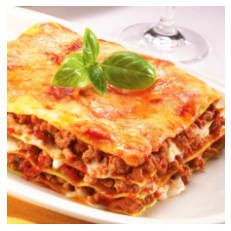

RECIPE 1

Title: Lasagna

Ingredients:
cheese, noodles, egg, basil, pepper, onion, salt, tomato, clove, beef

Instructions:
-Preheat oven to 350 degrees f (175 degrees c).
-Bring a large pot of lightly salted water to a boil.
-Cook lasagna noodles in the boiling water, stirring occasionally until cooked through but firm to the bite, about 8 minutes.
-Drain.
-Heat a large skillet over medium-high heat.
-Cook and stir beef in the hot skillet until browned and crumbly, 5 to 7 minutes; drain and discard grease.
-Stir onion, garlic, and basil into ground beef; cook and stir until onion is tender, about 5 minutes.
-Stir tomato sauce, tomato sauce, salt, and black pepper into ground beef mixture; simmer until flavors blend, about 10 minutes.
-Spread 1/2 the sauce in the bottom of a 9x13-inch baking
RECIPE 2

Title: Lasagna bake

Ingredients:
cheese, noodles, egg, basil, pepper, onion, salt, tomato, clove, beef

Instructions:
-In a large nonstick skillet, cook beef and onion over medium heat u

In [32]:
for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])

In [33]:
outs['ingrs']

['cheese',
 'noodles',
 'egg',
 'basil',
 'pepper',
 'onion',
 'salt',
 'tomato',
 'clove',
 'beef']